**Задание 1.** Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).  
**Задание 2.** Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [203]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Attention, Bidirectional, BatchNormalization, Dropout, Conv1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [204]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2022-02-23 13:30:17--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 74.125.132.113, 74.125.132.100, 74.125.132.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.132.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/veohoco729v6kbal7f1blnnknns6s7aj/1645623000000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download [following]
--2022-02-23 13:30:17--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/veohoco729v6kbal7f1blnnknns6s7aj/1645623000000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs

In [205]:
data = pd.read_csv('/content/airline-passengers.csv')

In [206]:
a = np.array([1,2,3,4])
a.take(2)

3

In [207]:
data.head(2)

,Month,Passengers
0,1949-01,112
1,1949-02,118


In [208]:
data['Month'] = pd.to_datetime(data['Month'])

In [209]:
data['month'] = data['Month'].dt.month
data['year'] = data['Month'].dt.year
data['day_of_week'] = data['Month'].dt.dayofweek
data['quarter'] = data['Month'].dt.quarter
data['day_of_year'] = data['Month'].dt.day_of_year
# data['day'] = data['Month'].dt.day день везде первый

In [210]:
data.columns

Index(['Month', 'Passengers', 'month', 'year', 'day_of_week', 'quarter',
       'day_of_year'],
      dtype='object')

In [211]:
# Сделаем стандартизацию

cols = data.columns.tolist()
cols

['Month',
 'Passengers',
 'month',
 'year',
 'day_of_week',
 'quarter',
 'day_of_year']

In [212]:
features = cols[2:] # Первоначальный признак времени не берем в расчет
target = cols[1]

In [213]:
data.shape

(144, 7)

In [214]:
train_size = 110

# отступ теста от тренировки
bias = 5

# делим
train_data = data.iloc[:train_size][features + [target]]
val_data = data.iloc[train_size + bias:][features + [target]]

print(f'Размер тренировочного набора данных: {train_data.shape}, \n'
      f'Размер тестового набора данных: {val_data.shape}')

Размер тренировочного набора данных: (110, 6), 
Размер тестового набора данных: (29, 6)


In [215]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,month,year,day_of_week,quarter,day_of_year,Passengers
0,-1.551749,-1.547132,0.985399,-1.308154,-1.545565,112
1,-1.264871,-1.547132,-1.031232,-1.308154,-1.253302,118
2,-0.977993,-1.547132,-1.031232,-1.308154,-0.989323,132
3,-0.691115,-1.547132,0.481241,-0.419901,-0.697060,129
4,-0.404237,-1.547132,1.489557,-0.419901,-0.414225,121


In [216]:
# длина истории
x_len = 8

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10

In [217]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

9 119
20 124


In [218]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((110, 5), (110,), (20, 5), (20,))

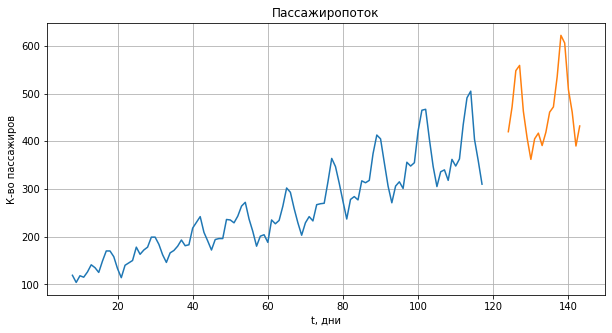

In [219]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('К-во пассажиров')
plt.title('Пассажиропоток')
plt.show()

На графике видно, что кривая изменения пассажиропотока изменяется стабильно циклично, следовательно, процессе предсказания не должен оказаться слишком сложным

In [220]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [221]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (32, 8, 5)
tf.Tensor(
[[-1.26487074 -1.54713187 -1.03123165 -1.30815427 -1.25330235]
 [-0.97799284 -1.54713187 -1.03123165 -1.30815427 -0.98932292]
 [-0.69111494 -1.54713187  0.48124144 -0.41990137 -0.69705998]
 [-0.40423704 -1.54713187  1.48955683 -0.41990137 -0.41422487]
 [-0.11735914 -1.54713187 -0.52707395 -0.41990137 -0.12196193]
 [ 0.16951876 -1.54713187  0.48124144  0.46835153  0.16087318]
 [ 0.45639666 -1.54713187 -1.53538934  0.46835153  0.45313612]
 [ 0.74327456 -1.54713187 -0.02291626  0.46835153  0.74539907]], shape=(8, 5), dtype=float64)
Target shape: (32,)
tf.Tensor(104, shape=(), dtype=int64)


Переходим к построению модели.

In [222]:
# Сначала создадим полезную функцию и заготовку словаря для записи результатов

results = {'model': [],
           'train mae': [],
           'test mae': []}

def evaluate_model(model, train_data, val_data):
  
    early_stop = EarlyStopping(monitor='val_loss', 
                                 patience=5,
                                 mode = 'auto',
                                 min_delta = 1e-3)

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=val_data,
                        callbacks=[early_stop],
                        verbose = 0)

    train_mae = history.history['mae'][-1]
    test_loss, test_mae = model.evaluate(val_data, verbose = 0)
    print(f'MAE train: {train_mae:.4f},\n'
        f'MAE test: {test_mae:.4f}')
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'][1:], 
              label='Средняя абсолютная ошибка на обучающей выборке')
    plt.plot(history.history['val_mae'][1:], 
              label='Средняя абсолютная ошибка на тестовой выборке')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

    return train_mae, test_mae

**SimpleRNN**

MAE train: 153.3588,
MAE test: 273.5703


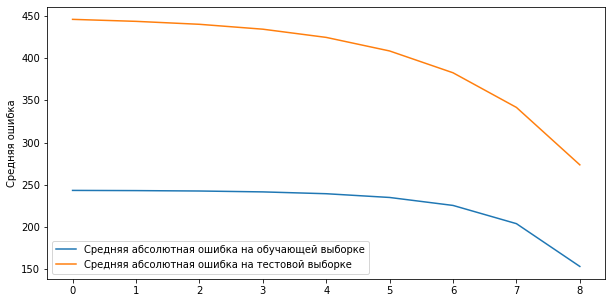

In [223]:
# Построим нейронную сеть

model1 = Sequential()

model1.add(SimpleRNN(64, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model1.add(SimpleRNN(64, return_sequences=True))
model1.add(Conv1D(32, 3, activation='linear'))
model1.add(Conv1D(32, 1, activation='linear'))
model1.add(Flatten())
model1.add(Dense(28, activation='linear'))
model1.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model1, dataset_train, dataset_val)

results['model'].append('model1 RNN')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

MAE train: 64.6768,
MAE test: 84.2111


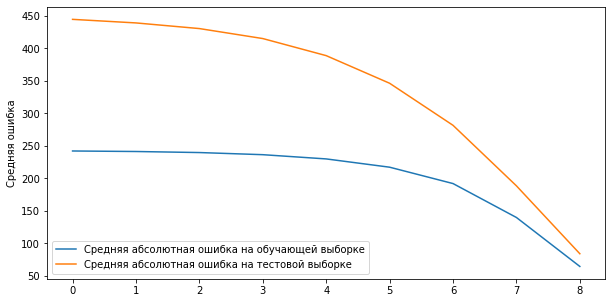

In [224]:
model2 = Sequential()

model2.add(Bidirectional(
    SimpleRNN(64, return_sequences=True), 
    input_shape=(inputs.shape[1], inputs.shape[2])))
model2.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
model2.add(Conv1D(32, 3, activation='linear'))
model2.add(Conv1D(32, 1, activation='linear'))
model2.add(Flatten())
model2.add(Dense(28, activation='linear'))
model2.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model2, dataset_train, dataset_val)

results['model'].append('model2 RNN + Bidirectional')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

**LSTM**

MAE train: 133.4969,
MAE test: 147.7658


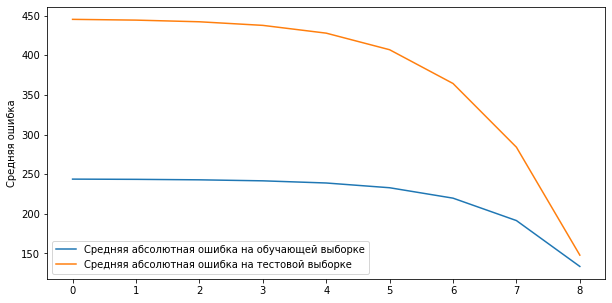

In [225]:

model3 = Sequential()

model3.add(LSTM(64, input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=True))
model3.add(LSTM(64, return_sequences=True))
model3.add(Conv1D(32, 3, activation='linear'))
model3.add(Conv1D(32, 1, activation='linear'))
model3.add(Flatten())
model3.add(Dense(28, activation='linear'))
model3.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model3, dataset_train, dataset_val)

results['model'].append('model3 LSTM')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

MAE train: 92.5379,
MAE test: 57.9372


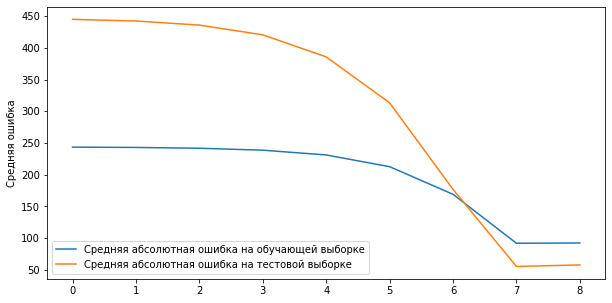

In [226]:
model4 = Sequential()

model4.add(Bidirectional(
    LSTM(64, return_sequences=True),
    input_shape=(inputs.shape[1], inputs.shape[2])))
model4.add(Bidirectional(LSTM(64, return_sequences=True)))
model4.add(Conv1D(32, 3, activation='linear'))
model4.add(Conv1D(32, 1, activation='linear'))
model4.add(Flatten())
model4.add(Dense(28, activation='linear'))
model4.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model4, dataset_train, dataset_val)

results['model'].append('model4 LSTM+Bidirectional')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

**GRU**

MAE train: 64.8070,
MAE test: 37.7336


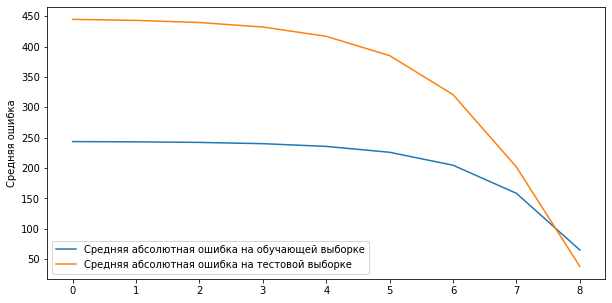

In [227]:

model5 = Sequential()

model5.add(GRU(64, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
model5.add(GRU(64, return_sequences=True))
model5.add(Conv1D(32, 3, activation='linear'))
model5.add(Conv1D(32, 1, activation='linear'))
model5.add(Flatten())
model5.add(Dense(28, activation='linear'))
model5.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model5, dataset_train, dataset_val)

results['model'].append('model5 GRU')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

MAE train: 94.2939,
MAE test: 45.6094


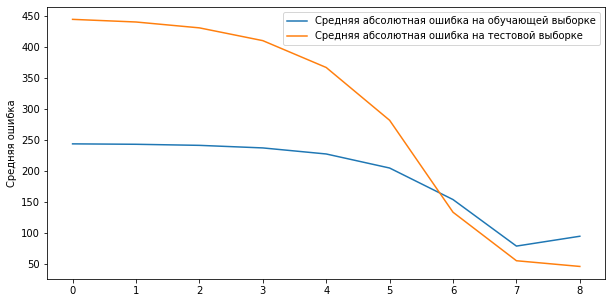

In [228]:
model6 = Sequential()

model6.add(Bidirectional(
    GRU(64, return_sequences=True),
    input_shape=(inputs.shape[1], inputs.shape[2])))
model6.add(Bidirectional(GRU(64, return_sequences=True)))
model6.add(Conv1D(32, 3, activation='linear'))
model6.add(Conv1D(32, 1, activation='linear'))
model6.add(Flatten())
model6.add(Dense(28, activation='linear'))
model6.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model6, dataset_train, dataset_val)

results['model'].append('model6 GRU+Bidirectional')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

In [229]:
results

{'model': ['model1 RNN',
  'model2 RNN + Bidirectional',
  'model3 LSTM',
  'model4 LSTM+Bidirectional',
  'model5 GRU',
  'model6 GRU+Bidirectional'],
 'test mae': [273.5702819824219,
  84.21113586425781,
  147.7658233642578,
  57.93721008300781,
  37.733638763427734,
  45.609439849853516],
 'train mae': [153.35877990722656,
  64.67680358886719,
  133.49693298339844,
  92.53791809082031,
  64.80695343017578,
  94.29386901855469]}

In [230]:
pd.DataFrame(results)

,model,train mae,test mae
0,model1 RNN,153.358780,273.570282
1,model2 RNN + Bidirectional,64.676804,84.211136
2,model3 LSTM,133.496933,147.765823
3,model4 LSTM+Bidirectional,92.537918,57.937210
4,model5 GRU,64.806953,37.733639
5,model6 GRU+Bidirectional,94.293869,45.609440


Наилуший результат при равных базовых параметрах достигается моделью GRU (model 5). Попробуем ее улучшить подбором параметров.

MAE train: 67.3123,
MAE test: 85.6431


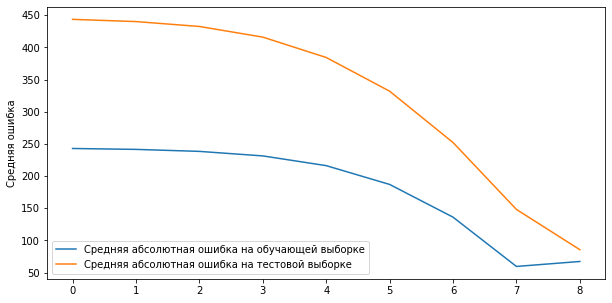

In [238]:
# Увеличим количество скрытых состояний в слоях GRU, а также нейронов и каналов в полносвязных и конвалюционных слоях
model7 = Sequential()

model7.add(GRU(128, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
model7.add(GRU(128, return_sequences=True))
model7.add(Conv1D(64, 3, activation='linear'))
model7.add(Conv1D(64, 1, activation='linear'))
model7.add(GlobalMaxPooling1D()) #Сделаем MaxPooling вместо Flatten
# model8.add(Flatten())

model7.add(Dense(32, activation='linear'))
model7.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model7, dataset_train, dataset_val)

In [239]:
model7.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_328 (GRU)               (None, 8, 128)            51840     
                                                                 
 gru_329 (GRU)               (None, 8, 128)            99072     
                                                                 
 conv1d_284 (Conv1D)         (None, 6, 64)             24640     
                                                                 
 conv1d_285 (Conv1D)         (None, 6, 64)             4160      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_349 (Dense)           (None, 32)                2080      
                                                    

Метрика ухудшилась, возможно следует увеличить количество слоев 

In [240]:
results['model'].append('model7 GRU more hidden')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

MAE train: 120.0424,
MAE test: 34.8876


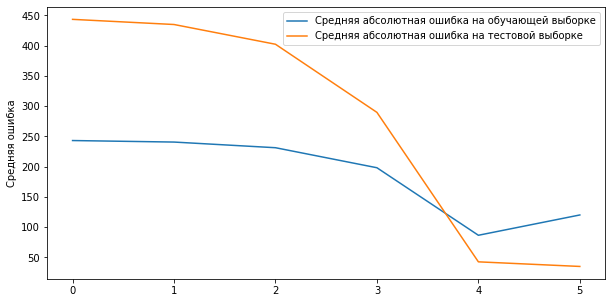

In [248]:
# Увеличим количество рекурретных слоев

# batch_size = 15 # уменьшили и результат стал лучше
epochs = 7 # уменьшили 

model8 = Sequential()

model8.add(GRU(128, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
model8.add(GRU(64, return_sequences=True))
model8.add(GRU(64, return_sequences=True))
model8.add(GRU(64, return_sequences=True))

model8.add(Conv1D(64, 3 , activation='linear'))
model8.add(Conv1D(32, 1, activation='linear'))
model8.add(Flatten())

model8.add(Dense(64, activation='linear'))
model8.add(Dense(32, activation='linear'))
model8.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model8, dataset_train, dataset_val)

Отлично! С увеличением количества скрытых состояний, ошибка стала еще меньше, однако есть сильное переобучение.

In [249]:
results['model'].append('model8 GRU more Rlayers')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

MAE train: 44.0717,
MAE test: 44.4946


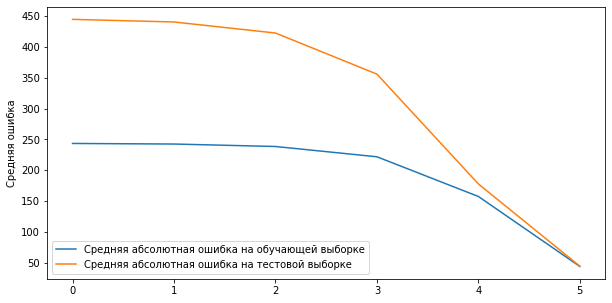

In [251]:
# Эксперимент - Попробуем реализовать сразу два типа рекурретных слоев

model9 = Sequential()

model9.add(GRU(64, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
model9.add(GRU(64, return_sequences=True))
# model9.add(GRU(64, return_sequences=True))
model9.add(Bidirectional(LSTM(64, return_sequences=True)))
model9.add(Bidirectional(LSTM(64, return_sequences=True)))

model9.add(Conv1D(32, 3 , activation='linear'))
model9.add(Conv1D(16, 1, activation='linear'))
model9.add(Flatten())

model9.add(Dense(64, activation='linear'))
model9.add(Dense(32, activation='linear'))
model9.add(Dense(1, activation='linear'))

train_mae, test_mae = evaluate_model(model9, dataset_train, dataset_val)

In [252]:
results['model'].append('model10 GRU + LSTM')
results['train mae'].append(train_mae)
results['test mae'].append(test_mae)

In [264]:
res = pd.DataFrame(results)

In [263]:
res

,model,train mae,test mae
0,model1 RNN,153.358780,273.570282
1,model2 RNN + Bidirectional,64.676804,84.211136
2,model3 LSTM,133.496933,147.765823
3,model4 LSTM+Bidirectional,92.537918,57.937210
4,model5 GRU,64.806953,37.733639
5,model6 GRU+Bidirectional,94.293869,45.609440
6,model7 GRU more hidden,67.312263,85.643112
7,model8 GRU more Rlayers,120.042351,34.887627
8,model10 GRU + LSTM,44.071659,44.494637


**Вывод:** Наилучший результат получился у модели с использованием GRU. Улучшить результат помогло:  
* подбор оптимальных параметров обучения (epochs). 
* увеличение количества рекурретных слоев 
* подбор оптимального количества скрытых состояний. 
  
Лучшей стала модель 8
  
Дополнительно был проведен эксперимент с моделью, где рекурретные слои состояли из GRU и LSTM - результат получился неплохой.